## Training Functions

### Plot graph

In [1]:
import nnfs
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data, vertical_data

nnfs.init()

def plot_prediction_performance(
    model: list | tuple,
    X, y,
    num_points: int = 100,
    device: str = 'cpu'
) -> None:
    """Plots the performance of the model in the spiral dataset with 3 categories"""
    def probabilities_to_rgb(probabilities_array):
        """ Maps an array of probabilities to RGB colors."""
        # Ensure that probabilities sum up to 1 for all data points
        if not torch.all(torch.isclose(torch.sum(probabilities_array, dim=1), torch.tensor(1.0).to(device))):
            raise ValueError("Probabilities must sum up to 1 for all data points.")
        
        # Map probabilities to RGB channels (0-255) for all data points
        r, g, b = (probabilities_array * 255).to(torch.int32).T
        
        # Return the RGB colors as a torch tensor
        return torch.stack((r, g, b), dim=1)

    # Create a meshgrid of points in the (-1,1)x(-1,1) space
    x_val = torch.linspace(-1, 1, num_points)
    y_val = torch.linspace(-1, 1, num_points)
    x_grid, y_grid = torch.meshgrid(x_val, y_val, indexing='xy')
    
    # Flatten the grids into 1D arrays
    x_flat = x_grid.flatten()
    y_flat = y_grid.flatten()
    
    # Combine the flattened arrays into an Nx2 array
    XX_tuples = torch.stack((x_flat, y_flat), dim=1).to(device)
    
    # Perform a forward pass through the network
    with torch.no_grad():
        model.eval()
        logits = model(XX_tuples)
        probabilities = torch.softmax(logits, dim=1)
    
    rgb_colors = probabilities_to_rgb(probabilities)
    probs_2d = rgb_colors.reshape(num_points, num_points, 3)
    
    # Assumed 3 categories - change this if different
    colors = ['r' if label == 0 else 'g' if label == 1 else 'b' for label in y]
    
    plt.imshow(probs_2d.cpu().numpy(), extent=(-1, 1, -1, 1), interpolation='bilinear')
    plt.scatter(X[:, 0].cpu(), -X[:, 1].cpu(), c=colors)
    plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

def plot_evolution(w_Cs, w_A, window_size=20):
    w_A = np.convolve(w_A, np.ones(window_size), 'valid') / window_size
    time = np.linspace(0, 1, len(w_A))

    w_Cs = np.array(w_Cs)
    w_Cs = w_Cs.T

    fig, ax = plt.subplots(figsize=(8, 6))
    
    for w_C in w_Cs:
        # smooth the data with a moving average
        w_C = np.convolve(w_C, np.ones(window_size), 'valid') / window_size
        # Create segments for the line
        points = np.array([w_A, w_C]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a line collection
        norm = Normalize(vmin=time.min(), vmax=time.max())  # Normalize time values
        lc = LineCollection(segments, cmap="viridis", norm=norm, alpha=0.7)
        lc.set_array(time)  # Use time to color the line
        ax.add_collection(lc)

        # plot initial and final points
        ax.scatter(w_A[0], w_C[0], c='r', alpha=1, zorder=10)
        ax.scatter(w_A[-1], w_C[-1], c='b', alpha=1, zorder=10)
   
        
    ax.autoscale()  # Adjust axis limits
    ax.set_xlabel("W_A")
    ax.set_ylabel("W_C")
    ax.grid(True) 
    

    # Add a colorbar to show time progression
    cbar = plt.colorbar(lc, ax=ax)
    cbar.set_label("Time")
    
    ax.set_title("Final result: {:.3f}".format(np.mean(w_Cs[:, -1])))
    plt.show()

## SHD

In [3]:
def get_As_and_Cs(model):
    Cs, As = [], []
    for param in model.parameters():
        analog_tile = param.analog_tile
        # Access the TransferCompound device
        device_weights = analog_tile.get_hidden_parameters()
        A = device_weights['hidden_weights_0']
        C = device_weights['hidden_weights_1']
        As.append(A)
        Cs.append(C)
    return torch.stack(Cs), torch.stack(As)

In [4]:
import torch
import torch.nn as nn
from aihwkit.nn import AnalogLinear
from aihwkit.simulator.presets import AGADEcRamPreset
from aihwkit.optim import AnalogSGD
from aihwkit.simulator.tiles.transfer_for_batched_TTv2 import TorchTransferTile

rpu_config = AGADEcRamPreset()
rpu_config.device.random_selection = False
rpu_config.device.scale_transfer_lr = True
rpu_config.device.transfer_lr = 1
rpu_config.device.fast_lr = 0.01
rpu_config.device.transfer_columns = True
rpu_config.device.transfer_every = 1
#rpu_config.update.desired_bl = 2000
rpu_config.mapping.digital_bias = False
#rpu_config.device.auto_granularity = 500
#pu_config.device.auto_scale = False
rpu_config.batch_size = 1


# Define two parallel networks
class Network(nn.Module):
    def __init__(self, device='cpu'):
        super(Network, self).__init__()
        self.l1 = TorchTransferTile(in_size=1, out_size=1, rpu_config=rpu_config).to(device)

    def forward(self, x):
        x = self.l1(x)
        return x

model = Network()
model.l1.get_hidden_parameters()

OrderedDict([('max_bound_0', tensor([[1.2352]])),
             ('min_bound_0', tensor([[-0.7785]])),
             ('dwmin_up_0', tensor([[0.0018]])),
             ('dwmin_down_0', tensor([[0.0018]])),
             ('decay_scales_0', tensor([[1.]])),
             ('diffusion_rates_0', tensor([[0.]])),
             ('reset_bias_0', tensor([[0.]])),
             ('drift_nu_0', tensor([[0.]])),
             ('slope_up_0', tensor([[-8.4344e-05]])),
             ('slope_down_0', tensor([[0.0010]])),
             ('max_bound_1', tensor([[1.1912]])),
             ('min_bound_1', tensor([[-0.8674]])),
             ('dwmin_up_1', tensor([[0.0021]])),
             ('dwmin_down_1', tensor([[0.0020]])),
             ('decay_scales_1', tensor([[1.]])),
             ('diffusion_rates_1', tensor([[0.]])),
             ('reset_bias_1', tensor([[0.]])),
             ('drift_nu_1', tensor([[0.]])),
             ('slope_up_1', tensor([[-0.0001]])),
             ('slope_down_1', tensor([[0.0012]])),
      

In [5]:
print(model.l1.rpu_config.device)

DynamicTransferCompound(
    unit_cell_devices=[
        EcRamPresetDevice(),
        EcRamPresetDevice()
    ],
    fast_lr=0.01,
    transfer_forward=PresetIOParameters(bound_management=BoundManagementType.NONE, noise_management=NoiseManagementType.NONE),
    transfer_update=PresetUpdateParameters(desired_bl=1, update_bl_management=False, update_management=False),
    in_chop_prob=0.005,
    auto_granularity=750,
    auto_scale=True,
    tail_weightening=50.0
)


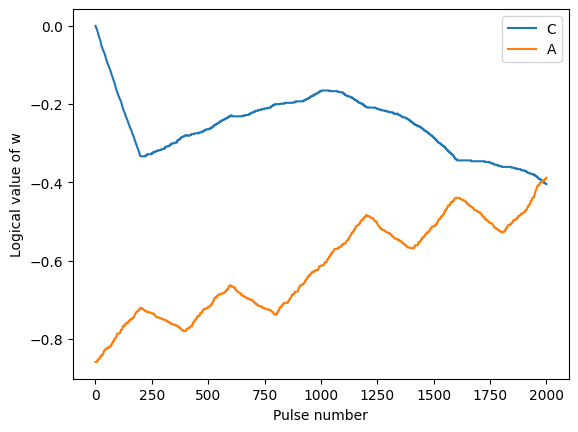

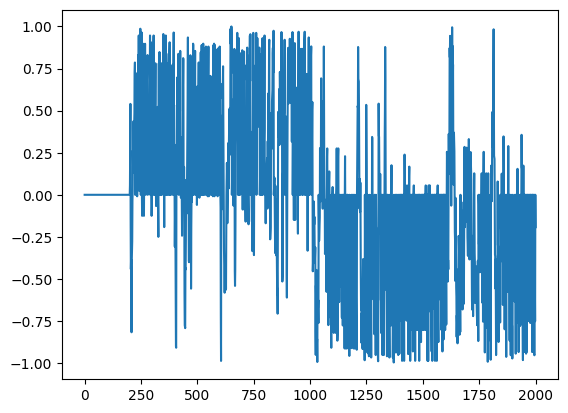

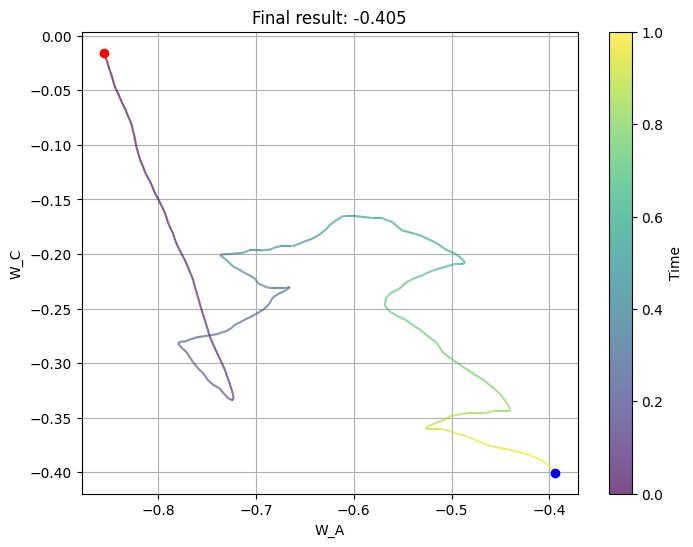

In [6]:
model = Network()

optimizer = AnalogSGD(model.parameters(), lr=3.5)
# lr from optimizer is the lr of the C matrix, only if scale_transfer_lr is True,
# lr of C = lr * transfer_lr
# else it does nothing and the lr of the C matrix is the one defined by transfer_lr
# the only way to control lr of A is through fast_lr


params = model.l1.get_hidden_parameters()
params['fast_weight'] = params['min_bound_0']
params['slow_weight_1'] = torch.tensor([[0]])
model.l1.set_hidden_parameters(params)

w_C = [[params['slow_weight_1'].item()]]
w_A = [params['fast_weight'].item()]
W_Buff = [params['hidden_weight'].item()]

for i in range(2000):
    if i < 1000:
        y = model(torch.tensor([[1.0]]))
        l = (1 - y)
    else:
        y = model(torch.tensor([[1.0]]))
        l = y

    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    params = model.l1.get_hidden_parameters()
    w_C.append([params['slow_weight_1'].item()])
    w_A.append(params['fast_weight'].item())
    W_Buff.append(params['hidden_weight'].item())

plt.plot(w_C, label='C')
plt.plot(w_A, label='A')
plt.xlabel('Pulse number')
plt.ylabel('Logical value of w')
plt.legend()
plt.show()
plt.plot(W_Buff, label='W_Buff')
plot_evolution(w_C, w_A)

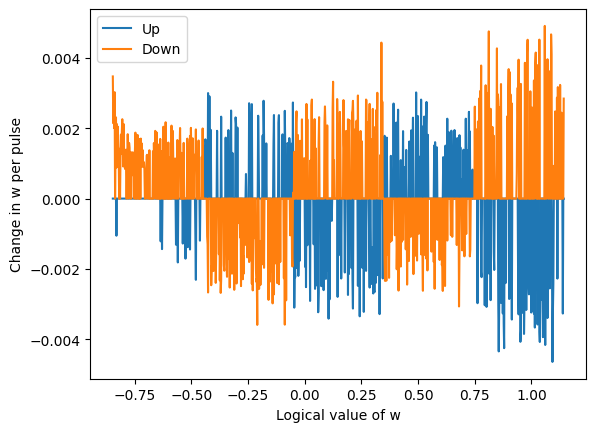

In [13]:
model = Network()

optimizer = AnalogSGD(model.parameters())


# for a seuqnece of points of values between -1 and 1 for conductance,
# get the resulting value for the update

params = model.l1.get_hidden_parameters()
minb = params['min_bound_0'].item()
maxb = params['max_bound_0'].item()
conductance = torch.linspace(minb+0.04, maxb-0.04, 1000)
up_result = []
down_result = []

for c in conductance:
    params = model.l1.get_hidden_parameters()
    params['fast_weight'] = torch.tensor([[c]])
    model.l1.set_hidden_parameters(params)
    out = model(torch.tensor([[10.0]]))
    out.backward()
    optimizer.step()
    optimizer.zero_grad()
    down_result.append(c - model.l1.get_hidden_parameters()['fast_weight'].item())

for c in conductance:
    params = model.l1.get_hidden_parameters()
    params['fast_weight'] = torch.tensor([[c]])
    model.l1.set_hidden_parameters(params)                                  
    out = model(torch.tensor([[-1.0]]))
    out.backward()
    optimizer.step()
    optimizer.zero_grad()
    up_result.append(model.l1.get_hidden_parameters()['fast_weight'].item() - c)

plt.plot(conductance, up_result, label='Up')
plt.plot(conductance, down_result, label='Down')
plt.xlabel('Logical value of w')
plt.ylabel('Change in w per pulse')
plt.legend()
plt.show()

## Training

In [14]:
from IPython.display import clear_output

def training_run(X, y, model, optimizer, loss_fn, epochs, batch_size=1):
    loss = []
    accuracy = []
    # save in a list the historical values of a weight of dense2_C and the same neuron in dense2_A
    # neuron = 0
    # weight = 0
    # num_tiles = model.l1.tile.num_tiles

    # params = model.l1.get_hidden_parameters()
    # w_C = [[params[f'slow_weight_{i}'][neuron][weight].item() for i in range(1, num_tiles + 1)]]
    # w_A = [params['fast_weight'][neuron][weight].item()]

    
    for e in range(epochs):
        model.train()
        # reshuffle the data
        perm = torch.randperm(len(X))
        X = X[perm]
        y = y[perm]
        # batch the data
        X_batched = torch.split(X, batch_size)
        y_batched = torch.split(y, batch_size)
        for x, y_true in zip(X_batched, y_batched):
            output = model(x)
            l = loss_fn(output, y_true)

            # backward pass
            l.backward()

            # update params
            optimizer.step()
            optimizer.zero_grad()

            # save in a list the historical values of a weight of dense2_C and the same neuron in dense2_A
            # params = model.l1.get_hidden_parameters()
            # w_C.append([params[f'slow_weight_{i}'][neuron][weight].item() for i in range(1, num_tiles + 1)])
            # w_A.append(params['fast_weight'][neuron][weight].item())

        model.eval()
        real_output = model(X)
        loss.append(loss_fn(real_output, y).item())
        if isinstance(loss_fn, nn.CrossEntropyLoss):
            correct_predictions = torch.sum(torch.argmax(real_output, axis=1) == y)
            accuracy.append(correct_predictions.item() / len(y))

        if (e+1) % 200 == 0:
            clear_output(wait=True)
            plt.plot(loss)
            plt.title(f'Final Loss: {np.mean(loss[-20:]):.2f}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()
            if accuracy != []:
                plt.plot(accuracy)
                plt.title(f'Final Accuracy: {np.mean(accuracy[-20:]):.2f}')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.show()
        
        if np.isnan(loss[-1]):
            break

    return loss, accuracy, w_C, w_A


### Spiral_data

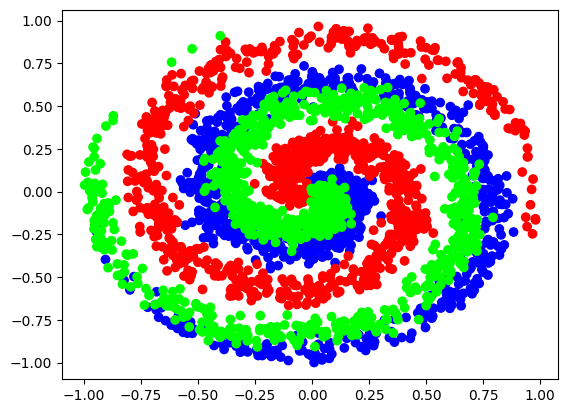

In [15]:
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)

# plot spiral data
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='brg')

In [ ]:
from aihwkit.simulator.configs import PrePostProcessingParameter, InputRangeParameter

class Analog_Network_spiral(nn.Module):
    
    def __init__(self, rpu_config=AGADEcRamPreset(), t=[5, 1], device='cpu'):
        super(Analog_Network_spiral, self).__init__()
        # rpu_config.mapping.digital_bias = False
        # rpu_config.forward.out_scale = 5
        # rpu_config.mapping.weight_scaling_omega = 0.2
        # rpu_config.mapping.learn_out_scaling = True

        
        ## CHEATING
        # rpu_config.device.unit_cell_devices[0].dw_min = 0.0002
        # rpu_config.device.unit_cell_devices[1].dw_min = 0.0002
        # rpu_config.device.transfer_forward.is_perfect = True
        # rpu_config.forward.is_perfect = True
        # rpu_config.backward.is_perfect = True

        ## FURTHER TESTING
        # rpu_config.forward.inp_res = 1/510 # 9 bits
        # rpu_config.forward.max_bm_res = 1/512 # 9 bits
        # rpu_config.forward.out_noise = 0.1
        # rpu_config.device.transfer_forward.inp_res = 1/510 # 9 bits
        # rpu_config.pre_post = PrePostProcessingParameter(input_range=InputRangeParameter())

        ## DO NOT SEEM TO MATTER MUCH
        # rpu_config.update.desired_bl = 20000
        # rpu_config.device.transfer_update.desired_bl = 20000
        # rpu_config.device.unit_cell_devices[0].dw_min_std = 0.0
        # rpu_config.device.unit_cell_devices[1].dw_min_std = 0.0
        # rpu_config.device.unit_cell_devices[0].mult_noise = False
        # rpu_config.device.unit_cell_devices[1].mult_noise = False
        
        
        rpu_config.device.units_in_mbatch = True
        rpu_config.device.transfer_every = t[0]
        self.l1 = TorchTransferTile(2, 64, bias=True, rpu_config=rpu_config).to(device)
        rpu_config.device.transfer_every = t[1]
        self.l2 = TorchTransferTile(64, 3, bias=True, rpu_config=rpu_config).to(device)

        batch_size = self.l1.rpu_config.batch_size

        # initialize weights  
        l1_weights = self.l1.get_weights()[0][0]
        #innit_w = [torch.nn.init.xavier_normal_(l1_weights) for _ in range(rpu_config.batch_size)]
        innit_w = torch.nn.init.xavier_normal_(l1_weights)
        params = self.l1.get_hidden_parameters()
        params.update({f'slow_weight_{i+1}': innit_w for i in range(batch_size)})
        params.update({f'fast_weight': torch.zeros_like(innit_w)})
        self.l1.set_hidden_parameters(params)

        l2_weights = self.l2.get_weights()[0][0]
        innit_w = torch.nn.init.xavier_normal_(l2_weights)
        params = self.l2.get_hidden_parameters()
        params.update({f'slow_weight_{i+1}': innit_w for i in range(batch_size)})
        params.update({f'fast_weight': torch.zeros_like(innit_w)})
        self.l2.set_hidden_parameters(params)    


    def forward(self, x):
        if self.training:
            x = torch.relu(self.l1(x)) 
            x = self.l2(x)
            return x * 25
        else:
            # create averaged network
            with torch.no_grad():
                w_l1 = torch.mean(self.l1.get_weights()[0], dim=0)
        #         self.l1_n = AnalogLinear(2, 64, bias=True, rpu_config=self.l1.rpu_config).to(x.device)
        #         self.l1_n.set_weights(w_l1, bias=self.l1.get_weights()[1])
                self.l1_n = nn.Linear(64, 2, bias=True).to(x.device)
                self.l1_n.weight.data = w_l1
                self.l1_n.bias.data = self.l1.get_weights()[1]
                w_l2 = torch.mean(self.l2.get_weights()[0], dim=0)
        #         self.l2_n = AnalogLinear(64, 3, bias=True, rpu_config=self.l2.rpu_config).to(x.device)
        #         self.l2_n.set_weights(w_l2, bias=self.l2.get_weights()[1])
                self.l2_n = nn.Linear(64, 3, bias=True).to(x.device)
                self.l2_n.weight.data = w_l2
                self.l2_n.bias.data = self.l2.get_weights()[1]

                x = torch.relu(self.l1_n(x))
                x = self.l2_n(x)
                return x * 25
        


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
batch_size = 128

rpu = AGADEcRamPreset()
rpu.device.fast_lr = 0.0128
rpu.batch_size = 1
t = [20, 1]
rpu.forward.out_noise = 0.04
#rpu.forward.is_perfect = True

model = Analog_Network_spiral(rpu_config=rpu, t=t).to(device)

print(model.l1.tile.device_config.transfer_every)

20


#### Grid search

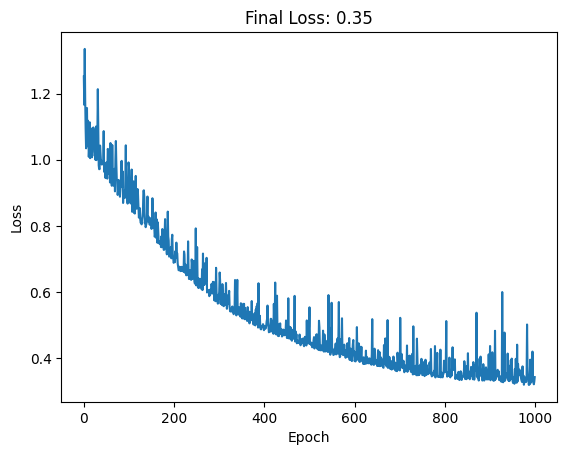

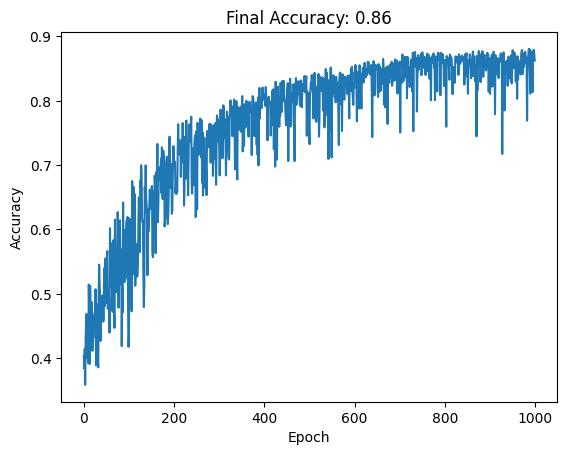

In [60]:
# grid search for hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
batch_size = 64
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

# grid search
learning_rate_C = [0.0064]
learning_rate_A = [0.0512, 0.1024]
t = [[1, 1]]

best_loss = float('inf')
best_accuracy = 0
results = []

for lr_C in learning_rate_C:
    for lr_A in learning_rate_A:
            for t_ in t:
                l = []
                a = []
                for _ in range(5):
                    rpu = AGADEcRamPreset()
                    rpu.device.in_chop_prob = 0.001
                    rpu.batch_size = 1
                    rpu.device.fast_lr = lr_A
                    rpu.forward.out_noise = 0.04
                    model = Analog_Network_spiral(rpu_config=rpu, t=t_, device=device)
                    optimizer = AnalogSGD(model.parameters(), lr=lr_C)
                    loss, accuracy, _, _ = training_run(X, y, model, optimizer, nn.CrossEntropyLoss(), 1000, batch_size=batch_size)
                    l.append(loss)
                    a.append(accuracy)
                #print(f'Loss: {loss:.2f}, accuracy: {accuracy:.2f} for params: lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}')
                results.append({
                    'lr_C': lr_C,
                    'lr_A': lr_A,
                    't': t_,
                    'loss': np.mean(l),
                    'accuracy': np.mean(a)
                })
                    # if loss < best_loss:
                    #     best_loss = loss
                    #     best_accuracy = accuracy
                    #     best_params = f'lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}'

#print(f'Best loss: {best_loss}, best accuracy: {best_accuracy} for params: {best_params}')

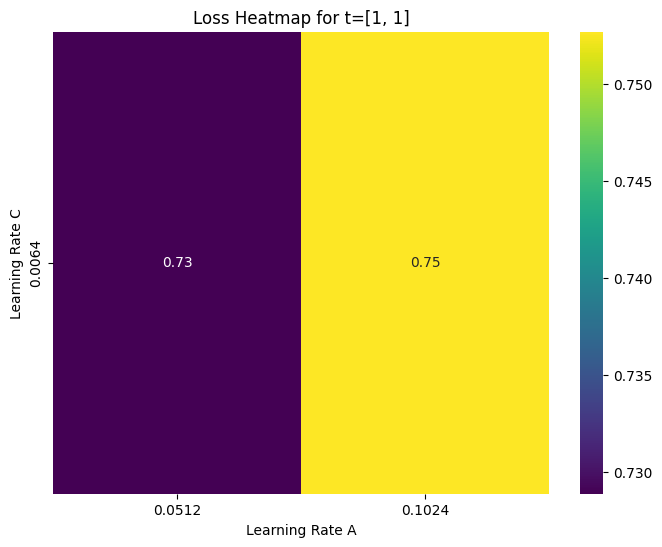

In [61]:
import pandas as pd

# Convert results to DataFrame
df = pd.DataFrame(results)

import seaborn as sns
import matplotlib.pyplot as plt

# Filter by specific `t_` if needed
t_fixed = [1, 1]  # Example
filtered_df = df[df['t'].apply(lambda x: x == t_fixed)]

# Pivot table for heatmap
heatmap_data = filtered_df.pivot(index="lr_C", columns="lr_A", values="accuracy")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis")
plt.title(f"Loss Heatmap for t={t_fixed}")
plt.xlabel("Learning Rate A")
plt.ylabel("Learning Rate C")
plt.show()

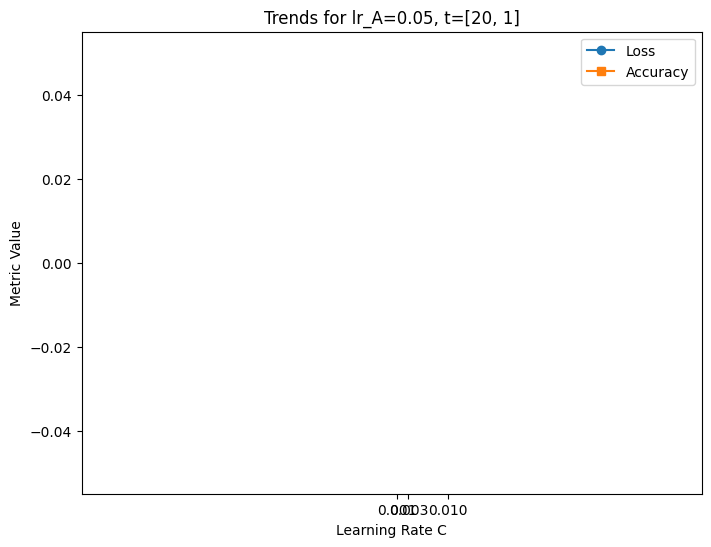

In [ ]:
# Example: Plot loss vs lr_C for a fixed lr_A and t
lr_A_fixed = 0.05
t_fixed = [1, 1]

filtered_df = df[(df['lr_A'] == lr_A_fixed) & (df['t'].apply(lambda x: x == t_fixed))]

plt.figure(figsize=(8, 6))
plt.plot(filtered_df['lr_C'], filtered_df['loss'], marker='o', label="Loss")
plt.plot(filtered_df['lr_C'], filtered_df['accuracy'], marker='s', label="Accuracy")
plt.xlabel("Learning Rate C")
plt.ylabel("Metric Value")
plt.xticks(learning_rate_C)
plt.title(f"Trends for lr_A={lr_A_fixed}, t={t_fixed}")
plt.legend()
plt.show()

#### Run

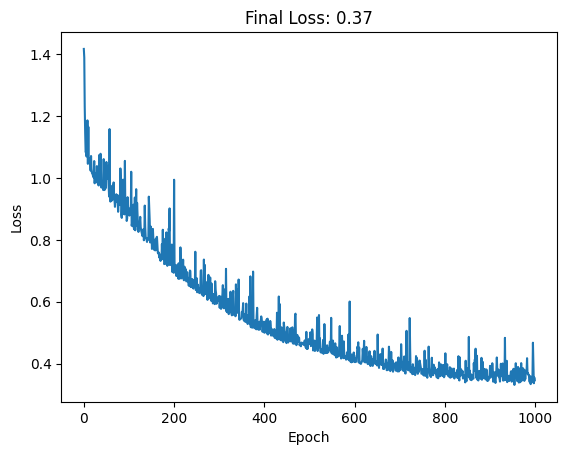

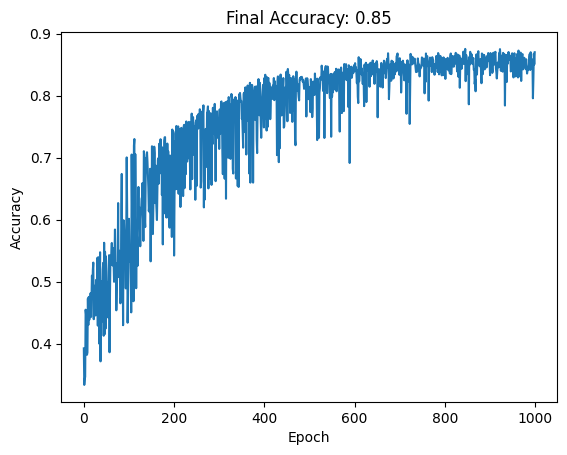

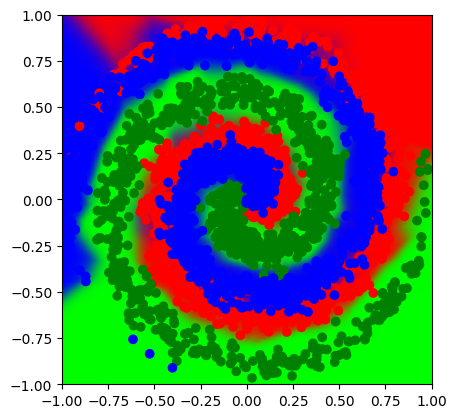

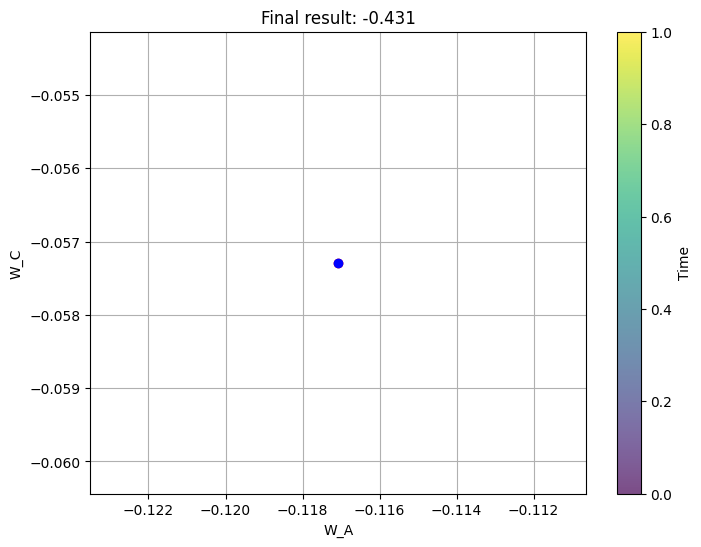

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
batch_size = 64

rpu = AGADEcRamPreset()
rpu.device.fast_lr = 0.0064 * 16
rpu.device.in_chop_prob = 0.001
rpu.batch_size = 4
t = [1, 1]
rpu.forward.out_noise = 0.04
rpu.device.transfer_forward.out_noise = 0.04
#rpu.forward.is_perfect = True

model = Analog_Network_spiral(rpu_config=rpu, t=t).to(device)
optimizer = AnalogSGD(model.parameters(), lr=0.0064)

loss_fn = nn.CrossEntropyLoss()

loss, accuracy, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 1000, batch_size=batch_size)

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)

plot_evolution(w_C, w_A, window_size=10000)

In [19]:
print(model.l1.rpu_config)

TTv2EcRamPreset(
    runtime=RuntimeParameter(),
    pre_post=PrePostProcessingParameter(input_range=InputRangeParameter(enable=False)),
    mapping=MappingParameter(),
    forward=PresetIOParameters(out_noise=0.04),
    backward=PresetIOParameters(),
    update=PresetUpdateParameters(desired_bl=100),
    device=ChoppedTransferCompound(
        unit_cell_devices=[
            EcRamPresetDevice(),
            EcRamPresetDevice()
        ],
        units_in_mbatch=True,
        fast_lr=0.0064,
        transfer_forward=PresetIOParameters(bound_management=BoundManagementType.NONE, noise_management=NoiseManagementType.NONE),
        transfer_update=PresetUpdateParameters(desired_bl=1, update_bl_management=False, update_management=False),
        in_chop_prob=0.0,
        auto_granularity=500,
        auto_scale=True
    )
)


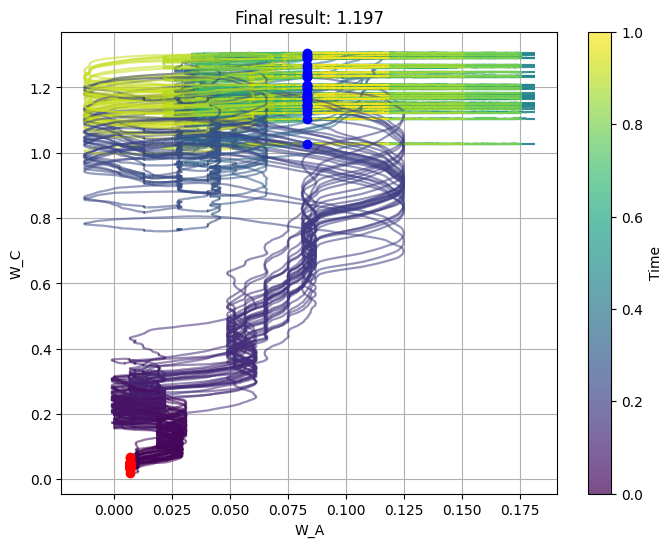

In [30]:
plot_evolution(w_C, w_A, window_size=500)

### Synthetic data -> regression

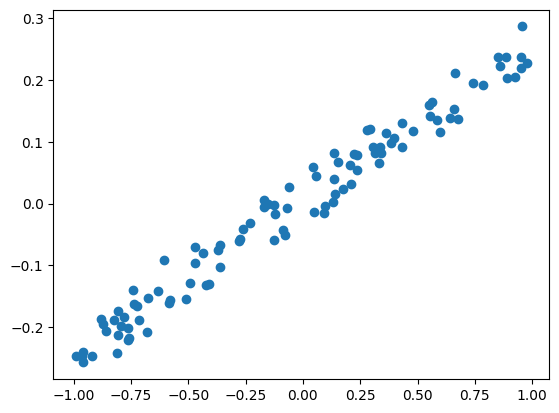

In [9]:
# generate a 100 point dataset for a linear regression problem with 1 feature
def generate_linear_regression_data(num_points=100):
    X = np.random.uniform(-1, 1, (num_points, 1))
    y = 0.25 * X + np.random.normal(0, 0.025, (num_points, 1))
    return X, y

# plot the data
X, y = generate_linear_regression_data(100)
plt.scatter(X, y)

In [10]:
class Analog_Network_linear(nn.Module):
    def __init__(self, rpu_config=TikiTakaEcRamPreset(), t=[5], device='cpu'):
        super(Analog_Network_linear, self).__init__()
        rpu_config.device.transfer_every = t[0]
        self.l1 = TorchTransferTile(1, 1, bias=False, rpu_config=rpu_config).to(device)

    def forward(self, x):
        if self.training:
            x = self.l1(x)
            return x
        else:
            with torch.no_grad():
                # create averaged network
                w_l1 = torch.mean(torch.stack(self.l1.get_weights()[0]), dim=0)
                l1_n = AnalogLinear(1, 1, bias=False, rpu_config=self.l1.rpu_config).to(x.device)
                l1_n.set_weights(w_l1)
                return l1_n(x)
        

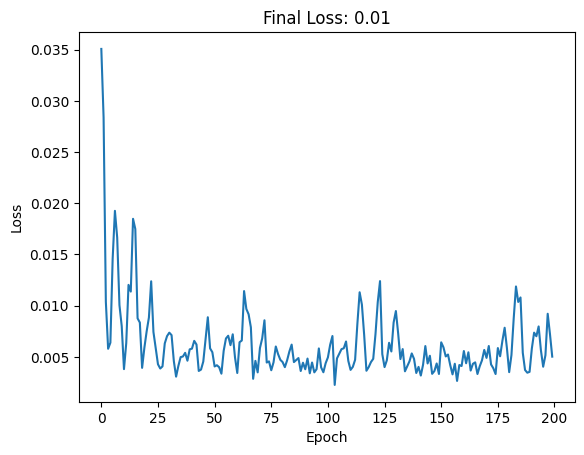

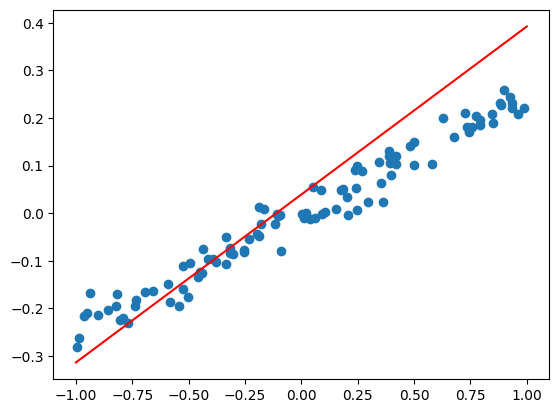

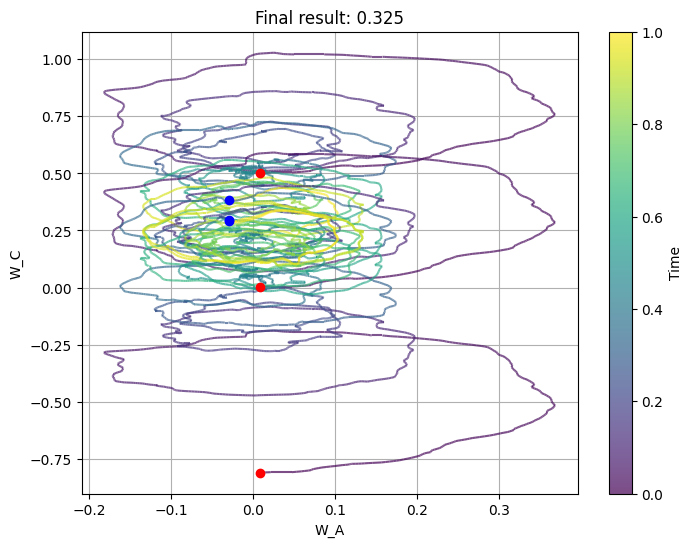

In [13]:
device = 'cpu'
X_np, y_np = generate_linear_regression_data(100)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.float32).to(device)
batch_size = 3
rpu = TikiTakaEcRamPreset()
rpu.device.fast_lr = 0.02
rpu.forward.out_noise = 0.1
rpu.batch_size = batch_size
t = [5]
model = Analog_Network_linear(rpu_config=rpu, t=t).to(device)

params = model.l1.get_hidden_parameters()
params['slow_weight_1'] = torch.tensor([[0.5]])
params['slow_weight_2'] = torch.tensor([[0]])
params['slow_weight_3'] = torch.tensor([[-1]])
# params['slow_weight_4'] = torch.tensor([[1]])
model.l1.set_hidden_parameters(params)

optimizer = AnalogSGD(model.parameters(), lr=0.05)
loss_fn = nn.MSELoss()

loss, _, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 200, batch_size=batch_size)

# plot the linear regression line over the data
model.eval()
X_line = torch.tensor([[-1], [1]], dtype=torch.float32).to(device)
output = model(X_line)
y_line = output.detach().cpu().numpy()
plt.scatter(X_np, y_np)
plt.plot([-1, 1], y_line, c='r')
plt.show()

plot_evolution(w_C, w_A, window_size=10)

(-1.1, 1.1)

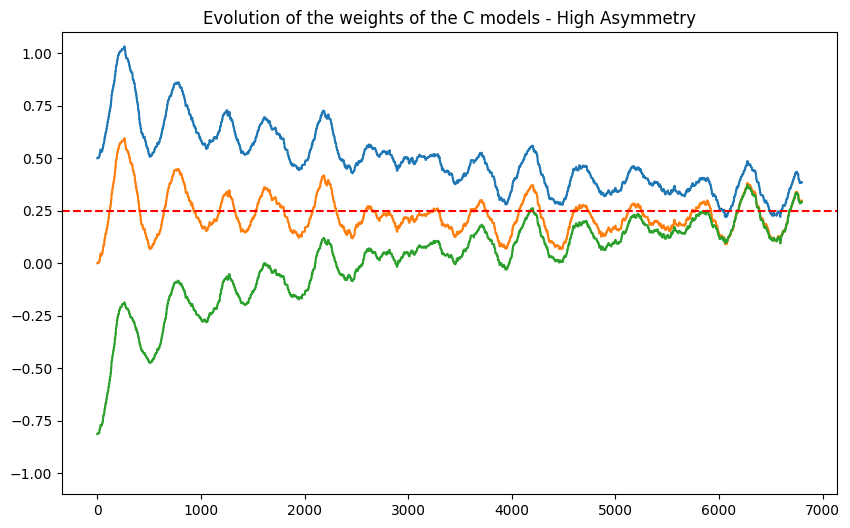

In [16]:
plt.figure(figsize=(10, 6))
for i in range(len(w_C[0])):
    plt.plot([w_C[j][i] for j in range(len(w_C))])
# plot the reference horizontal line at solution y = 1
plt.axhline(y=0.25, color='r', linestyle='--')
plt.title('Evolution of the weights of the C models - High Asymmetry')
# the y axis should go from -1 to 1.1
plt.ylim(-1.1, 1.1)

In [50]:
model.eval()
X_line = torch.tensor([[-1], [1]], dtype=torch.float32).to(device)
output = model(X_line)
output

tensor([[-0.4706],
        [ 0.2353]], grad_fn=<AnalogFunctionBackward>)

In [51]:
print(model.l1.get_weights())

torch.mean(torch.stack(model.l1.get_weights()[0]))

([tensor([[0.4952]]), tensor([[0.4881]]), tensor([[0.3277]]), tensor([[0.4671]])], None)


tensor(0.4445)

## Extra experiments

In [9]:
class Analog_Network_linear(nn.Module):
    def __init__(self, rpu_config=TikiTakaEcRamPreset(), t=[5], device='cpu'):
        super(Analog_Network_linear, self).__init__()
        rpu_config.device.transfer_every = t[0]
        self.l1 = AnalogLinear(1, 1, bias=False, rpu_config=rpu_config).to(device)

    def forward(self, x):
        x = self.l1(x)
        return x

In [ ]:
model.l1.named_analog_tiles

<bound method AnalogLayerBase.named_analog_tiles of AnalogLinear(
  in_features=1, out_features=1, bias=True, TikiTakaEcRamPreset
  (analog_module): AnalogTile(RPUPulsed<float>[Transfer(2): LinearStep -> LinearStep](1,1))
)>

In [ ]:
from aihwkit.simulator.configs import NoiseManagementType
from aihwkit.simulator.presets import BatchedTikiTakaEcRamPreset

device = 'cpu'
rpu = BatchedTikiTakaEcRamPreset()
rpu.device.fast_lr = 0.1
t = [5]
rpu.forward.inp_noise = 0.0
rpu.forward.out_noise = 0.1
rpu.forward.noise_management = NoiseManagementType.NONE
model = Analog_Network_linear(rpu_config=rpu, t=t).to(device)
rpu.forward.inp_noise

In [82]:
rpu.get_default_tile_module_class()

aihwkit.simulator.tiles.analog.AnalogTile

In [ ]:
input = torch.tensor(10).view(1, 1)
model.l1.set_weights(weight = torch.tensor([[0.5]]))

l1 =  model.l1.get_weights()[0] @ input
print('Real output:', l1)

results = []
for i in range(10000):
    results.append(model(input))
print('Mean: ', torch.stack(results).mean(dim=0))
print('Std: ', torch.stack(results).std(dim=0))
print('Signal to noise ratio: ', torch.stack(results).mean(dim=0) / torch.stack(results).std(dim=0))

Real output: tensor([[0.2500]])
Mean:  tensor([[0.2450]], grad_fn=<MeanBackward1>)
Std:  tensor([[0.1029]], grad_fn=<StdBackward0>)
Signal to noise ratio:  tensor([[2.3816]], grad_fn=<DivBackward0>)


In [69]:
model.l1.set_weights(weight = torch.tensor([[0.5]]))
input = torch.linspace(-1, 1, 100).view(-1, 1, 1)
target_output = []
std = []

for i in input: 
    l1 =  model.l1.get_weights()[0] @ i
    target_output.append(l1.item())
    results = []
    for _ in range(1000):
        results.append(model(i))
    std.append(torch.stack(results).std(dim=0).detach().numpy()[0])

Text(0, 0.5, 'Std')

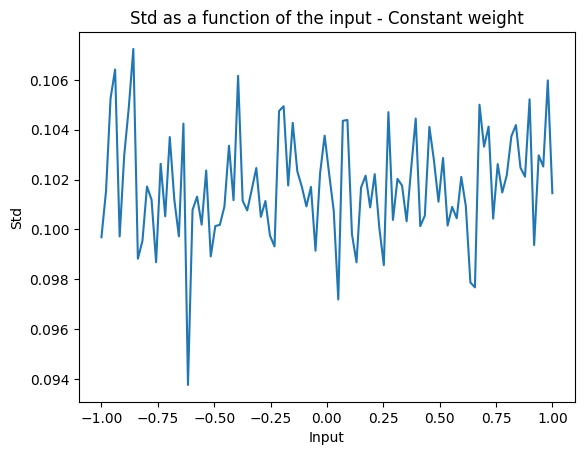

In [70]:
# plot std as a function of the input
plt.plot(input.view(-1), std, label='Std')
plt.title('Std as a function of the input - Constant weight')
plt.xlabel('Input')
plt.ylabel('Std')

In [64]:
weights = torch.linspace(-1, 1.2, 100).view(-1)
input = torch.tensor([[1.0]]).view(1, 1)
target_output = []
std = []

for w in weights: 
    model.l1.set_weights(weight = w)
    l1 =  model.l1.get_weights()[0] @ input
    target_output.append(l1.item())
    results = []
    for _ in range(2000):
        results.append(model(input))
    std.append(torch.stack(results).std(dim=0).detach().numpy()[0])

Text(0, 0.5, 'Std')

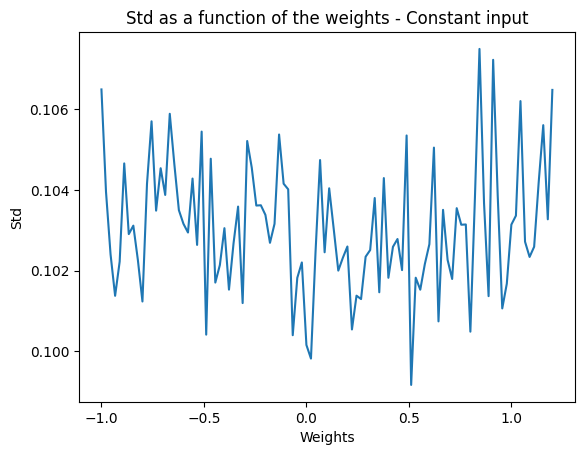

In [65]:
# plot std as a function of the weights
plt.plot(weights, std, label='Std')
plt.title('Std as a function of the weights - Constant input')
plt.xlabel('Weights')
plt.ylabel('Std')